# 短程-建立模型-平均價格_log

In [2]:
import pandas as pd

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 檢查是否有缺失值
print(data.isnull().sum())

出發日期                 0
星期                   0
出發時間                 0
出發時段                 0
出發機場代號               0
抵達時間                 0
抵達時段                 0
抵達機場代號               0
航空公司                 0
航空聯盟                 0
停靠站數量                0
停留時間                 0
飛行時間                 0
飛行時間_分鐘              0
是否過夜                 0
是否為平日                0
機型                   0
機型分類                 0
航班代碼                 0
艙等                   0
假期                   0
平均價格                 0
最低價格                 0
中位數價格                0
價格變異                 0
隨機購買平均價格             0
最低價格剩餘天數             0
筆數                   0
平均價格_log             0
最低價格_log             0
價格變異_log             0
中位數價格_log            0
最低價格天數               0
Region               0
經濟指標                 0
機場指標                 0
competing_flights    0
dtype: int64


**特徵重要性圖**

Average Performance over 5 runs:
RandomForest:
  MSE = 0.0450
  R^2 = 0.9198
  RMSE = 0.2121
  Adjusted R^2 = 0.9190
XGBoost:
  MSE = 0.0397
  R^2 = 0.9293
  RMSE = 0.1992
  Adjusted R^2 = 0.9286
SVR:
  MSE = 0.0449
  R^2 = 0.9200
  RMSE = 0.2118
  Adjusted R^2 = 0.9192


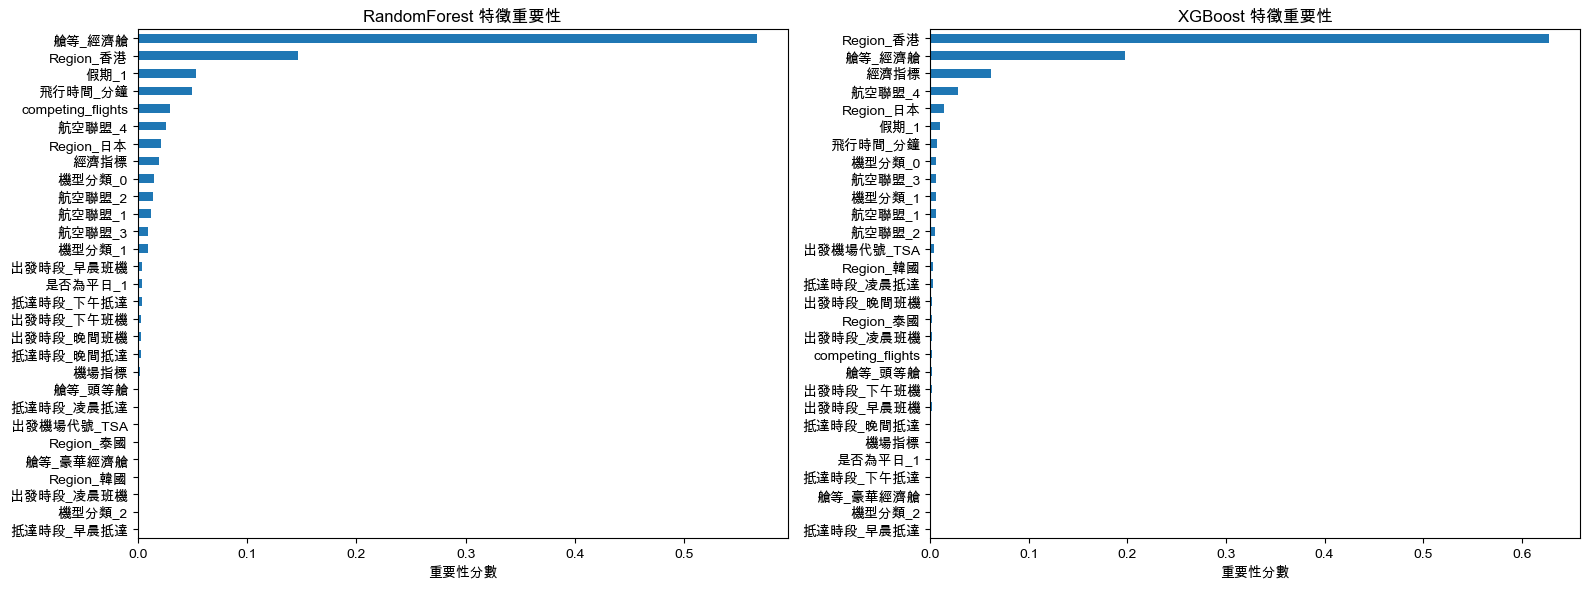

In [10]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '機型分類', '是否過夜', '是否為平日', '機型', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_', '艙等_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練、評估與特徵重要性計算
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    feature_importance = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    # 提取隨機森林特徵重要性
    rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importance['RandomForest'] = rf_importance
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1, verbosity=0)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    # 提取 XGBoost 特徵重要性
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importance['XGBoost'] = xgb_importance
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    # SVR 沒有特徵重要性，因此這邊跳過
    
    return result, feature_importance

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}
all_feature_importance = {'RandomForest': [], 'XGBoost': []}

for res, feat_imp in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])
    # 收集每個隨機種子下的特徵重要性 (只收集 RF 與 XGB)
    all_feature_importance['RandomForest'].append(feat_imp['RandomForest'])
    all_feature_importance['XGBoost'].append(feat_imp['XGBoost'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

# 畫圖：以隨機種子 123 的結果為例，繪製 RandomForest 與 XGBoost 的特徵重要性
rf_importance = all_feature_importance['RandomForest'][0]
xgb_importance = all_feature_importance['XGBoost'][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RandomForest 特徵重要性圖
rf_importance.sort_values().plot(kind='barh', ax=axes[0])
axes[0].set_title("RandomForest 特徵重要性")
axes[0].set_xlabel("重要性分數")

# XGBoost 特徵重要性圖
xgb_importance.sort_values().plot(kind='barh', ax=axes[1])
axes[1].set_title("XGBoost 特徵重要性")
axes[1].set_xlabel("重要性分數")

plt.tight_layout()
plt.show()

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據，指定「停留城市」為字串
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
dtype_spec = {"停留城市": str}
data = pd.read_csv(file_path, dtype=dtype_spec)

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號', '機場分類',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', '艙等_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 定義單次運行的函數，針對一個隨機種子進行資料分割、模型訓練與評估
def run_model(seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    
    result = {}
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}
    
    # SVR
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}
    
    return result

# 設定要運行的隨機種子數量
seeds = [123, 234, 345, 456, 567]

# 平行化運算每個隨機種子下的結果
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理三個模型各自的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算各模型的平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted_R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(len(seeds)))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted_R2']:.4f}")

Average Performance over 5 runs:
RandomForest:
  MSE = 0.0434
  R^2 = 0.9218
  RMSE = 0.2083
  Adjusted R^2 = 0.9211
XGBoost:
  MSE = 0.0394
  R^2 = 0.9291
  RMSE = 0.1984
  Adjusted R^2 = 0.9284
SVR:
  MSE = 0.0488
  R^2 = 0.9120
  RMSE = 0.2210
  Adjusted R^2 = 0.9112


**30次平均**

In [11]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# One-hot encoding：針對多個分類欄位進行處理
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號', '機場分類',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)', 'competing_flights']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_', '機場分類_', '艙等_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)', 'competing_flights']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["平均價格_log"]

# 自變數數量（用於計算 Adjusted R²）
p = X.shape[1]

# 定義單次運行的函數（針對一個隨機種子訓練與評估三個模型）
def run_model(seed):
    # 分割資料集 (70% 訓練，30% 測試)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    
    result = {}

    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    adjusted_r_rf = 1 - (1 - r2_rf) * (n_test - 1) / (n_test - p - 1)
    result['RandomForest'] = {'MSE': mse_rf, 'R2': r2_rf, 'RMSE': rmse_rf, 'Adjusted_R2': adjusted_r_rf}

    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mse_svr)
    adjusted_r_svr = 1 - (1 - r2_svr) * (n_test - 1) / (n_test - p - 1)
    result['SVR'] = {'MSE': mse_svr, 'R2': r2_svr, 'RMSE': rmse_svr, 'Adjusted_R2': adjusted_r_svr}

    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, 
                             random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    adjusted_r_xgb = 1 - (1 - r2_xgb) * (n_test - 1) / (n_test - p - 1)
    result['XGBoost'] = {'MSE': mse_xgb, 'R2': r2_xgb, 'RMSE': rmse_xgb, 'Adjusted_R2': adjusted_r_xgb}

    return result

# 設定運行次數（30 次）與隨機種子列表
n_runs = 30
seeds = list(range(n_runs))

# 平行化運算（n_jobs 可自行調整）
all_results = Parallel(n_jobs=-1)(delayed(run_model)(seed) for seed in seeds)

# 整理每個模型的結果
results = {
    'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
    'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
}

for res in all_results:
    for model in results.keys():
        results[model]['MSE'].append(res[model]['MSE'])
        results[model]['R2'].append(res[model]['R2'])
        results[model]['RMSE'].append(res[model]['RMSE'])
        results[model]['Adjusted_R2'].append(res[model]['Adjusted_R2'])

# 計算平均結果
avg_results = {}
for model, metrics in results.items():
    avg_results[model] = {
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2']),
        'Average RMSE': np.mean(metrics['RMSE']),
        'Average Adjusted R2': np.mean(metrics['Adjusted_R2'])
    }

# 顯示結果
print("Average Performance over {} runs:".format(n_runs))
for model, scores in avg_results.items():
    print(f"{model}:")
    print(f"  MSE = {scores['Average MSE']:.4f}")
    print(f"  R^2 = {scores['Average R2']:.4f}")
    print(f"  RMSE = {scores['Average RMSE']:.4f}")
    print(f"  Adjusted R^2 = {scores['Average Adjusted R2']:.4f}")

Average Performance over 30 runs:
RandomForest:
  MSE = 0.0356
  R^2 = 0.9334
  RMSE = 0.1887
  Adjusted R^2 = 0.9328
SVR:
  MSE = 0.0361
  R^2 = 0.9324
  RMSE = 0.1900
  Adjusted R^2 = 0.9318
XGBoost:
  MSE = 0.0324
  R^2 = 0.9393
  RMSE = 0.1801
  Adjusted R^2 = 0.9388


**視覺化**

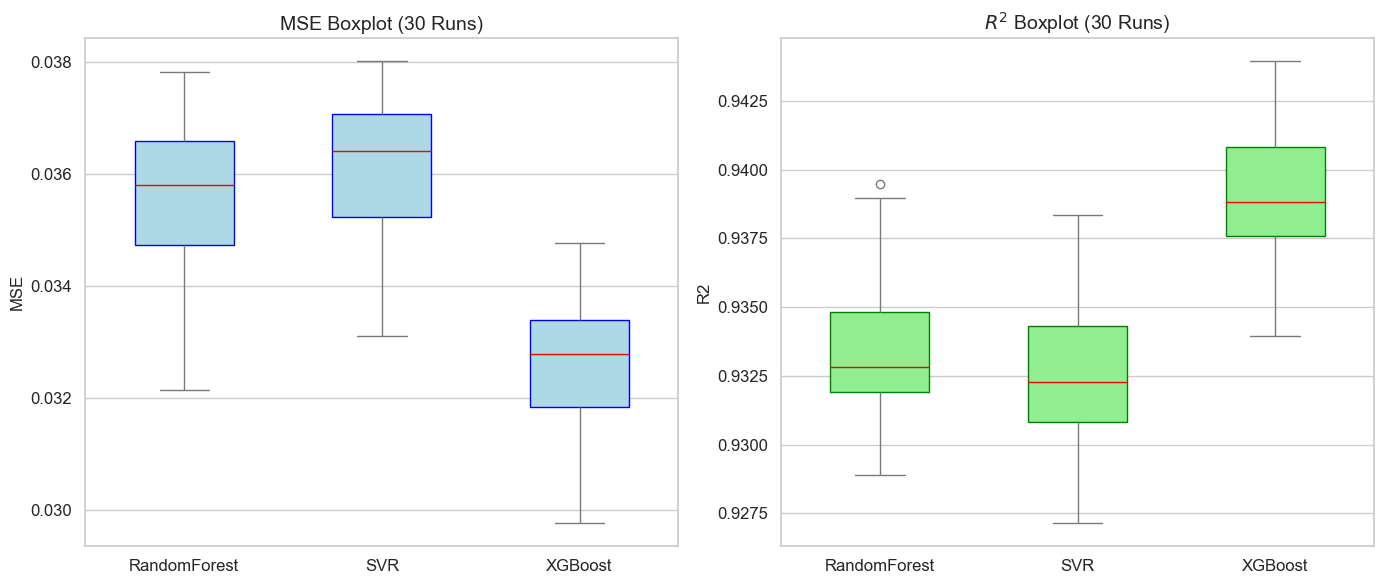

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假設 results 字典已包含各模型 30 次的結果
# 轉換資料格式
mse_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['MSE'],
    'SVR': results['SVR']['MSE'],
    'XGBoost': results['XGBoost']['MSE']
})
r2_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['R2'],
    'SVR': results['SVR']['R2'],
    'XGBoost': results['XGBoost']['R2']
})

# 使用 melt 將資料轉為長格式 (long-form)
mse_long = mse_df.melt(var_name='Model', value_name='MSE')
r2_long = r2_df.melt(var_name='Model', value_name='R2')

# 設定 Seaborn 主題
sns.set(style='whitegrid', palette='pastel')

# 建立圖形
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long, ax=axes[0],
            width=0.5, showfliers=True, 
            boxprops={'facecolor':'lightblue', 'edgecolor':'blue'},
            medianprops={'color': 'red'})
axes[0].set_title('MSE Boxplot (30 Runs)', fontsize=14)
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=12)

# R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long, ax=axes[1],
            width=0.5, showfliers=True,
            boxprops={'facecolor':'lightgreen', 'edgecolor':'green'},
            medianprops={'color': 'red'})
axes[1].set_title('$R^2$ Boxplot (30 Runs)', fontsize=14)
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()